# Savanna collab &mdash; local dataset exploration

The goal of this notebook is to demonstrate how data can be downloaded from the [Digital Earth Australia](https://docs.dea.ga.gov.au/) (DEA) database and represented locally, rather than having to be analysed via the DEA sandbox.

First, we can define the details of a demo region of interest (ROI) to explore:

In [1]:
demo_roi = {
    "product": "ga_ls_landcover_class_cyear_2",
    "asset": "canopyco_veg_cat_l4d",
    "year": 2018,
    "bbox": [
        129.975, -16.775, 130.025, -16.725,
    ],
}

## Finding the data intersecting with the required parameters

The DEA data is stored on a publically-accessible AWS host.
We now need to work out what files we need to access to obtain the data corresponding to the details of our ROI.

We can use the SpatioTemporal Asset Catalog (STAC) interface that is [provided by DEA](https://docs.dea.ga.gov.au/notebooks/How_to_guides/Downloading_data_with_STAC.html) to retrieve this information.
We can use the `pystac_client` package to assist:

In [2]:
import pystac_client

We can define a function that will return the metadata associated with a given query to the catalogue:

In [3]:
def get_metadata(product, datetime, bbox):
    
    root_url = "https://explorer.sandbox.dea.ga.gov.au/stac"

    client = pystac_client.Client.open(url=root_url)
    
    response = client.search(
        collections=[product],
        bbox=bbox,
        datetime=datetime,
    )

    return response

And then use it for our demo ROI:

In [4]:
metadata = get_metadata(
    product=demo_roi["product"], datetime=str(demo_roi["year"]), bbox=demo_roi["bbox"]
)

We can see how many files matched our query parameters:

In [5]:
metadata.matched()

1

Each `item` in `metadata` corresponds to a year in this dataset, so we can extract our year via:

In [6]:
(metadata,) = metadata.items()

This contains a lot of information about the file:

In [7]:
metadata

id: 11565a26-b739-4c2d-8297-82fe83b4590c
"bbox: [129.19307679950253, -16.881090424703523, 130.14215705336477, -15.957121434393198]"
title: ga_ls_landcover_class_cyear_2_1-0-0_au_2018-01-01
"platform: landsat-5,landsat-7,landsat-8"
odc:product: ga_ls_landcover_class_cyear_2
odc:producer: ga.gov.au
"instruments: ['tm, etm+, oli']"
odc:file_format: GeoTIFF
odc:region_code: au
odc:product_family: lc
odc:dataset_version: 1.0.0


Because we are interested in a particular 'asset', we can extract that info:

In [8]:
asset_metadata = metadata.assets[demo_roi["asset"]]

In [9]:
asset_metadata

href: s3://dea-public-data/derivative/ga_ls_landcover_class_cyear_2/1-0-0/2018/x_-3/y_-18/ga_ls_landcover_class_cyear_2_1-0-0_au_x-3y-18_2018-01-01_canopyco-veg-cat-l4d.tif
type: image/tiff; application=geotiff; profile=cloud-optimized
title: canopyco_veg_cat_l4d
roles: ['data']
owner: 11565a26-b739-4c2d-8297-82fe83b4590c
eo:bands: [{'name': 'canopyco_veg_cat_l4d'}]
proj:epsg: 3577
"proj:shape: [4000, 4000]"
"proj:transform: [25.0, 0.0, -300000.0, 0.0, -25.0, -1700000.0, 0.0, 0.0, 1.0]"


The most important key in that metadata is `href` &mdash; that tells us the link on AWS that we need to download to have local access to the data.

In [10]:
url = asset_metadata.href

In [11]:
url

's3://dea-public-data/derivative/ga_ls_landcover_class_cyear_2/1-0-0/2018/x_-3/y_-18/ga_ls_landcover_class_cyear_2_1-0-0_au_x-3y-18_2018-01-01_canopyco-veg-cat-l4d.tif'

## Downloading files from the AWS storage

To facilitate downloading from AWS, we can use the [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) package:

In [12]:
import boto3
import botocore

We will also use `pathlib` to help with paths:

In [13]:
import pathlib

Now we can define a helper function that downloads a file given an AWS URL:

In [14]:
def download_from_aws(url, save_dir, client=None):

    if client is None:
        config = botocore.client.Config(signature_version=botocore.UNSIGNED)
        client = boto3.client("s3", config=config)

    # some messy parsing of the S3 URL
    (bucket_name, *_) = url.removeprefix("s3://").split("/")
    remote_path = url.removeprefix(f"s3://{bucket_name}/")
    (*_, filename) = remote_path.split("/")
    
    local_path = pathlib.Path(save_dir) / filename
    
    client.download_file(Bucket=bucket_name, Key=remote_path, Filename=local_path)
    
    return local_path

In [15]:
local_path = download_from_aws(url=url, save_dir=pathlib.Path("."))

Now we have the file downloaded locally:

In [16]:
print(local_path)

ga_ls_landcover_class_cyear_2_1-0-0_au_x-3y-18_2018-01-01_canopyco-veg-cat-l4d.tif


And it has this many bytes:

In [17]:
local_file_size_bytes = local_path.stat().st_size
local_file_size_bytes

2148063

Which is:

In [18]:
f"{local_file_size_bytes / 1024 / 1024} MB"

'2.0485525131225586 MB'

## Reading a file stored locally

To then load and interpret the file stored locally, we can use [`rioxarray`](https://corteva.github.io/rioxarray/stable/index.html), which is a helper library for `xarray`.

In [19]:
import rioxarray
import xarray as xr

In [20]:
data = rioxarray.open_rasterio(local_path).load()
data

<xarray.DataArray (band: 1, y: 4000, x: 4000)>
array([[[13, 13, 13, ..., 15, 15, 15],
        [13, 13, 13, ..., 15, 15, 15],
        [13, 13, 13, ..., 15, 15, 15],
        ...,
        [15, 15, 15, ..., 13, 13, 13],
        [15, 15, 15, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3e+05 -3e+05 -2.999e+05 ... -2e+05 -2e+05
  * y            (y) float64 -1.7e+06 -1.7e+06 -1.7e+06 ... -1.8e+06 -1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

As you can see, we have the data and metadata for this chip.
We can then plot it to make sure it looks sensible:

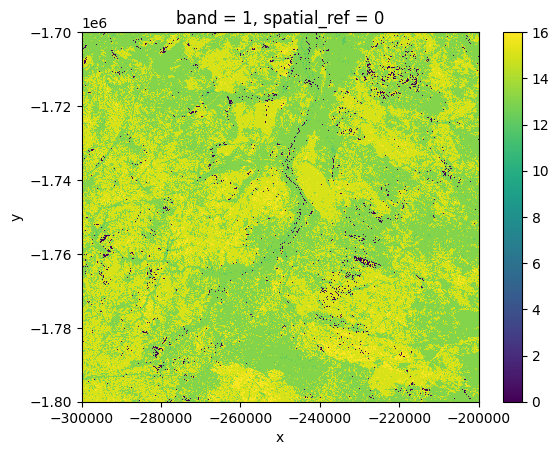

In [21]:
data.isel(band=0).plot();

## Transforming and cropping the data

There are two particularly noteable aspects of the above:
1. The dimensions are not in latitude / longitude, which is the coordinate system that we used in our demo ROI.
2. The data contains the entire spatial region of the chip, not just the bounding-box region of our demo ROI.

For the current purposes, we want to resolve both of those &mdash; generally though, neither of these will probably need attention.

First, we will 'reproject' the data into a latitude / longitude coordinate system:

In [22]:
data_latlon = data.rio.reproject("EPSG:4326", nodata=1)

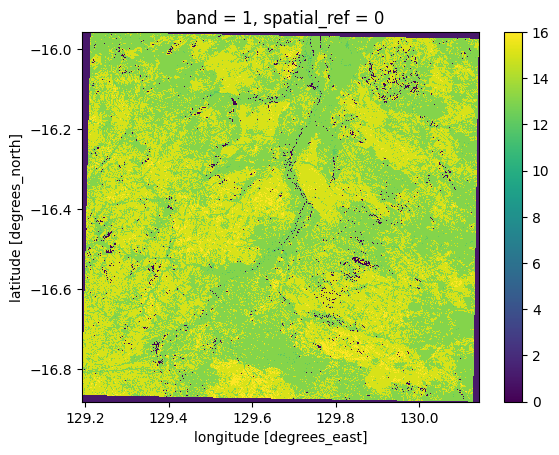

In [23]:
data_latlon.isel(band=0).plot();

So now our chip is in latitude / longitude.
Note that there are now areas around the edges that do not have any information due to the transformation.

Second, we can extract our specific bounding-box of interest:

We need to convert our bounding-box into GeoJSON format:

In [24]:
bbox_geom = [
    {
        "type": "Polygon",
        "coordinates": [
            [
                [demo_roi["bbox"][0], demo_roi["bbox"][1]],  # BL
                [demo_roi["bbox"][0], demo_roi["bbox"][3]],  # TL
                [demo_roi["bbox"][2], demo_roi["bbox"][3]],  # TR
                [demo_roi["bbox"][2], demo_roi["bbox"][1]],  # BR
            ]
        ],
    },
]

In [25]:
data_latlon_bbox = data_latlon.rio.clip(geometries=bbox_geom, all_touched=True)

And now we have our local region:

In [26]:
data_latlon_bbox

<xarray.DataArray (band: 1, y: 218, x: 218)>
array([[[13, 13, 13, ..., 15, 15, 15],
        [15, 13, 13, ..., 15, 15, 15],
        [15, 15, 13, ..., 15, 15, 15],
        ...,
        [15, 15, 15, ..., 15, 15, 15],
        [15, 15, 15, ..., 15, 15, 15],
        [15, 15, 15, ..., 15, 15, 15]]], dtype=uint8)
Coordinates:
  * x            (x) float64 130.0 130.0 130.0 130.0 ... 130.0 130.0 130.0 130.0
  * y            (y) float64 -16.73 -16.73 -16.73 ... -16.77 -16.77 -16.77
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     1

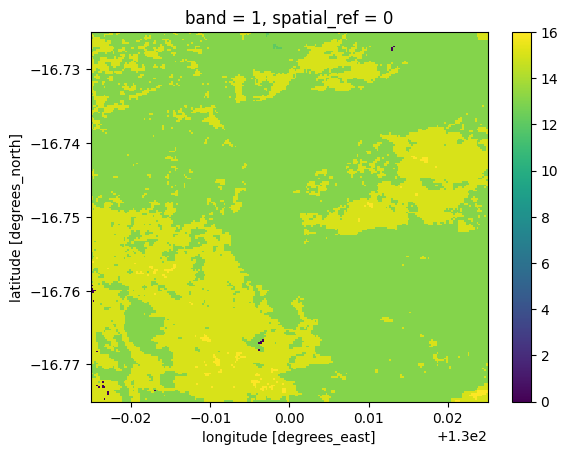

In [27]:
data_latlon_bbox.isel(band=0).plot();

For comparison with the sandbox, we can also just clip the original dataset:

Here, I am copying the coordinates found in the DEA sandbox:

In [28]:
bbox_transformed = [
    -216687.5,
    -1788537.5,
    -211237.5,
    -1782962.5,
]

bbox_geom_transformed = [
    {
        "type": "Polygon",
        "coordinates": [
            [
                [bbox_transformed[0], bbox_transformed[1]],  # BL
                [bbox_transformed[0], bbox_transformed[3]],  # TL
                [bbox_transformed[2], bbox_transformed[3]],  # TR
                [bbox_transformed[2], bbox_transformed[1]],  # BR
            ]
        ]
    },
]

In [29]:
data_bbox = data.rio.clip(geometries=bbox_geom_transformed, all_touched=True)

In [30]:
data_bbox

<xarray.DataArray (band: 1, y: 224, x: 219)>
array([[[13, 13, 13, ..., 15, 13, 15],
        [13, 13, 13, ..., 15, 15, 15],
        [13, 13, 13, ..., 15, 15, 15],
        ...,
        [15, 15, 15, ..., 15, 15, 15],
        [15, 15, 15, ..., 15, 15, 13],
        [15, 15, 15, ..., 13, 13, 13]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.167e+05 -2.167e+05 ... -2.113e+05 -2.112e+05
  * y            (y) float64 -1.783e+06 -1.783e+06 ... -1.789e+06 -1.789e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

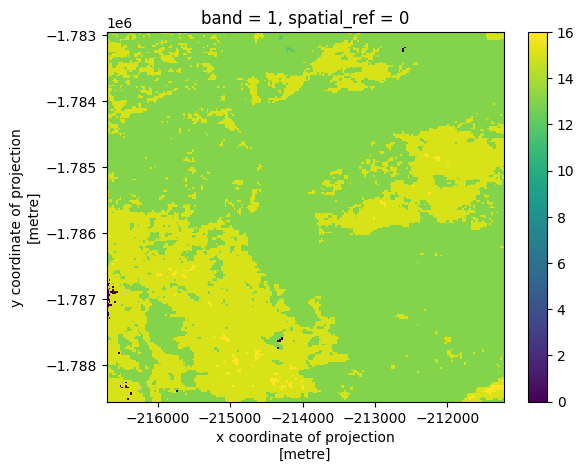

In [31]:
data_bbox.isel(band=0).plot();

Save it so we can compare in the DEA sandbox:

In [32]:
data_bbox.rio.to_raster("demo_roi_bbox_data.tif")

## Extending to the whole savanna region and all available times

I have downloaded the data for the whole savanna region (as provided in the GeoJSON file) and for all the available times.

In [33]:
chip_dir = pathlib.Path("./chips")

This consists of around 10,000 files:

In [34]:
len(list(chip_dir.glob("*.tif")))

9776

We will need to give some thought to how best to load and represent that data.